# Architektur Neuronales Netz Demirer et al.

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn import preprocessing


#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.LayerNorm(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.ReLU(),
            nn.Linear(input_size, hidden1_size), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden 
            nn.ReLU(),
            nn.Dropout(p = 0.01),
            nn.Linear(hidden1_size, hidden2_size),
            nn.ReLU(),
            nn.Linear(hidden2_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 1)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): ReLU()
    (1): Linear(in_features=5, out_features=200, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.01, inplace=False)
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=1, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs xi
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
xi = torch.tensor(res['xi'])

#Anpassen der Daten auf gleiche Größenordnung
#Bnorm = nn.BatchNorm1d(5)
T = log10(T)
p = p / 1000
# T = torch.tensor(res['T']).float()
# p = torch.tensor(res['p']).float()
# x_0 = torch.tensor(res['x_0']).float()
# xi = torch.tensor(res['xi']).float()

# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
#x_input = Bnorm(x_input)
y_output = xi.reshape((-1,1))
#print(x_input.size())
# print(xi.size())

# Tensoren zu einem großen Set gruppieren
dataset = TensorDataset(x_input, y_output)

# for x,y in dataset:
#     print(x)
#     print(y)
    
# Split in Trainings und Test Set
train_dataset, test_dataset = random_split(dataset, 
                                           [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
                                           generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 1)

# Loss Funktion; gibt Fehler an
loss_fn = nn.MSELoss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 0.02
#learnin_rate = 1e-4
optimizer = torch.optim.SGD(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
scheduler = MultiStepLR(optimizer, milestones=[30, 200], gamma = 0.1)

#### Funktion zur Bestimmung der Genauigkeit

In [7]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
            #print(pred.size())
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred, y)

            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if pred[i] - y[i] <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f} \n")

    net.train()
    
    return acc, loss, MRE

#### Training

In [8]:
num_epochs = 800 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients

#         # Record the correct predictions for training data
#         _, predictions = torch.max(pred.data, 1)
#         train_correct += (predictions == y.data).sum()                
#         train_total += predictions.size(0)    

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping
    #train_loss.append(loss.item())
    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)

#     loss = criterion(outputs, Variable(test_classes))
#     test_loss.append(loss.data[0])

Epoch 1/800, Iteration 1/12, Loss: 0.0055
Epoch 1/800, Iteration 2/12, Loss: 0.0076
Epoch 1/800, Iteration 3/12, Loss: 0.0050
Epoch 1/800, Iteration 4/12, Loss: 0.0043
Epoch 1/800, Iteration 5/12, Loss: 0.0055
Epoch 1/800, Iteration 6/12, Loss: 0.0045
Epoch 1/800, Iteration 7/12, Loss: 0.0038
Epoch 1/800, Iteration 8/12, Loss: 0.0048
Epoch 1/800, Iteration 9/12, Loss: 0.0065
Epoch 1/800, Iteration 10/12, Loss: 0.0043
Epoch 1/800, Iteration 11/12, Loss: 0.0043
Epoch 1/800, Iteration 12/12, Loss: 0.0065
Epoch 1/800, Iteration 13/12, Loss: 0.0045
Train Error: 
 Accuracy: 66.25%, Avg loss: 0.004436, MRE: 3.010362 

Test Error: 
 Accuracy: 62.5%, Avg loss: 0.004541, MRE: 4.029286 

Epoch 2/800, Iteration 1/12, Loss: 0.0051
Epoch 2/800, Iteration 2/12, Loss: 0.0058
Epoch 2/800, Iteration 3/12, Loss: 0.0057
Epoch 2/800, Iteration 4/12, Loss: 0.0036
Epoch 2/800, Iteration 5/12, Loss: 0.0037
Epoch 2/800, Iteration 6/12, Loss: 0.0054
Epoch 2/800, Iteration 7/12, Loss: 0.0058
Epoch 2/800, Iterati

Epoch 15/800, Iteration 5/12, Loss: 0.0023
Epoch 15/800, Iteration 6/12, Loss: 0.0020
Epoch 15/800, Iteration 7/12, Loss: 0.0022
Epoch 15/800, Iteration 8/12, Loss: 0.0020
Epoch 15/800, Iteration 9/12, Loss: 0.0018
Epoch 15/800, Iteration 10/12, Loss: 0.0022
Epoch 15/800, Iteration 11/12, Loss: 0.0019
Epoch 15/800, Iteration 12/12, Loss: 0.0029
Epoch 15/800, Iteration 13/12, Loss: 0.0015
Train Error: 
 Accuracy: 62.0%, Avg loss: 0.001653, MRE: 1.697852 

Test Error: 
 Accuracy: 59.5%, Avg loss: 0.001768, MRE: 3.296027 

Epoch 16/800, Iteration 1/12, Loss: 0.0016
Epoch 16/800, Iteration 2/12, Loss: 0.0012
Epoch 16/800, Iteration 3/12, Loss: 0.0020
Epoch 16/800, Iteration 4/12, Loss: 0.0027
Epoch 16/800, Iteration 5/12, Loss: 0.0025
Epoch 16/800, Iteration 6/12, Loss: 0.0020
Epoch 16/800, Iteration 7/12, Loss: 0.0021
Epoch 16/800, Iteration 8/12, Loss: 0.0022
Epoch 16/800, Iteration 9/12, Loss: 0.0019
Epoch 16/800, Iteration 10/12, Loss: 0.0014
Epoch 16/800, Iteration 11/12, Loss: 0.0014

Epoch 29/800, Iteration 13/12, Loss: 0.0016
Train Error: 
 Accuracy: 65.12%, Avg loss: 0.001534, MRE: 1.768145 

Test Error: 
 Accuracy: 62.5%, Avg loss: 0.001518, MRE: 3.525121 

Epoch 30/800, Iteration 1/12, Loss: 0.0013
Epoch 30/800, Iteration 2/12, Loss: 0.0023
Epoch 30/800, Iteration 3/12, Loss: 0.0016
Epoch 30/800, Iteration 4/12, Loss: 0.0025
Epoch 30/800, Iteration 5/12, Loss: 0.0015
Epoch 30/800, Iteration 6/12, Loss: 0.0020
Epoch 30/800, Iteration 7/12, Loss: 0.0018
Epoch 30/800, Iteration 8/12, Loss: 0.0015
Epoch 30/800, Iteration 9/12, Loss: 0.0016
Epoch 30/800, Iteration 10/12, Loss: 0.0020
Epoch 30/800, Iteration 11/12, Loss: 0.0020
Epoch 30/800, Iteration 12/12, Loss: 0.0015
Epoch 30/800, Iteration 13/12, Loss: 0.0013
Train Error: 
 Accuracy: 56.12%, Avg loss: 0.001492, MRE: 1.771840 

Test Error: 
 Accuracy: 54.0%, Avg loss: 0.001543, MRE: 4.198262 

Epoch 31/800, Iteration 1/12, Loss: 0.0012
Epoch 31/800, Iteration 2/12, Loss: 0.0017
Epoch 31/800, Iteration 3/12, Loss:

Epoch 42/800, Iteration 3/12, Loss: 0.0018
Epoch 42/800, Iteration 4/12, Loss: 0.0022
Epoch 42/800, Iteration 5/12, Loss: 0.0014
Epoch 42/800, Iteration 6/12, Loss: 0.0012
Epoch 42/800, Iteration 7/12, Loss: 0.0016
Epoch 42/800, Iteration 8/12, Loss: 0.0016
Epoch 42/800, Iteration 9/12, Loss: 0.0023
Epoch 42/800, Iteration 10/12, Loss: 0.0016
Epoch 42/800, Iteration 11/12, Loss: 0.0019
Epoch 42/800, Iteration 12/12, Loss: 0.0017
Epoch 42/800, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 60.25%, Avg loss: 0.001483, MRE: 1.724895 

Test Error: 
 Accuracy: 58.5%, Avg loss: 0.001506, MRE: 3.923207 

Epoch 43/800, Iteration 1/12, Loss: 0.0020
Epoch 43/800, Iteration 2/12, Loss: 0.0016
Epoch 43/800, Iteration 3/12, Loss: 0.0018
Epoch 43/800, Iteration 4/12, Loss: 0.0021
Epoch 43/800, Iteration 5/12, Loss: 0.0019
Epoch 43/800, Iteration 6/12, Loss: 0.0017
Epoch 43/800, Iteration 7/12, Loss: 0.0019
Epoch 43/800, Iteration 8/12, Loss: 0.0015
Epoch 43/800, Iteration 9/12, Loss: 0.0015


Epoch 55/800, Iteration 7/12, Loss: 0.0018
Epoch 55/800, Iteration 8/12, Loss: 0.0015
Epoch 55/800, Iteration 9/12, Loss: 0.0022
Epoch 55/800, Iteration 10/12, Loss: 0.0018
Epoch 55/800, Iteration 11/12, Loss: 0.0014
Epoch 55/800, Iteration 12/12, Loss: 0.0018
Epoch 55/800, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 59.25%, Avg loss: 0.001493, MRE: 1.730148 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001503, MRE: 3.985367 

Epoch 56/800, Iteration 1/12, Loss: 0.0016
Epoch 56/800, Iteration 2/12, Loss: 0.0017
Epoch 56/800, Iteration 3/12, Loss: 0.0015
Epoch 56/800, Iteration 4/12, Loss: 0.0016
Epoch 56/800, Iteration 5/12, Loss: 0.0021
Epoch 56/800, Iteration 6/12, Loss: 0.0020
Epoch 56/800, Iteration 7/12, Loss: 0.0014
Epoch 56/800, Iteration 8/12, Loss: 0.0017
Epoch 56/800, Iteration 9/12, Loss: 0.0014
Epoch 56/800, Iteration 10/12, Loss: 0.0016
Epoch 56/800, Iteration 11/12, Loss: 0.0019
Epoch 56/800, Iteration 12/12, Loss: 0.0017
Epoch 56/800, Iteration 13/12, Loss: 0.0

Train Error: 
 Accuracy: 59.88%, Avg loss: 0.001498, MRE: 1.713237 

Test Error: 
 Accuracy: 59.0%, Avg loss: 0.001493, MRE: 3.951362 

Epoch 68/800, Iteration 1/12, Loss: 0.0021
Epoch 68/800, Iteration 2/12, Loss: 0.0015
Epoch 68/800, Iteration 3/12, Loss: 0.0017
Epoch 68/800, Iteration 4/12, Loss: 0.0016
Epoch 68/800, Iteration 5/12, Loss: 0.0022
Epoch 68/800, Iteration 6/12, Loss: 0.0021
Epoch 68/800, Iteration 7/12, Loss: 0.0017
Epoch 68/800, Iteration 8/12, Loss: 0.0021
Epoch 68/800, Iteration 9/12, Loss: 0.0014
Epoch 68/800, Iteration 10/12, Loss: 0.0016
Epoch 68/800, Iteration 11/12, Loss: 0.0019
Epoch 68/800, Iteration 12/12, Loss: 0.0020
Epoch 68/800, Iteration 13/12, Loss: 0.0011
Train Error: 
 Accuracy: 61.12%, Avg loss: 0.001508, MRE: 1.727452 

Test Error: 
 Accuracy: 59.5%, Avg loss: 0.001486, MRE: 3.836266 

Epoch 69/800, Iteration 1/12, Loss: 0.0014
Epoch 69/800, Iteration 2/12, Loss: 0.0018
Epoch 69/800, Iteration 3/12, Loss: 0.0015
Epoch 69/800, Iteration 4/12, Loss: 

Train Error: 
 Accuracy: 61.25%, Avg loss: 0.001491, MRE: 1.747637 

Test Error: 
 Accuracy: 59.5%, Avg loss: 0.001479, MRE: 3.826431 

Epoch 81/800, Iteration 1/12, Loss: 0.0021
Epoch 81/800, Iteration 2/12, Loss: 0.0017
Epoch 81/800, Iteration 3/12, Loss: 0.0014
Epoch 81/800, Iteration 4/12, Loss: 0.0018
Epoch 81/800, Iteration 5/12, Loss: 0.0019
Epoch 81/800, Iteration 6/12, Loss: 0.0020
Epoch 81/800, Iteration 7/12, Loss: 0.0016
Epoch 81/800, Iteration 8/12, Loss: 0.0016
Epoch 81/800, Iteration 9/12, Loss: 0.0017
Epoch 81/800, Iteration 10/12, Loss: 0.0018
Epoch 81/800, Iteration 11/12, Loss: 0.0017
Epoch 81/800, Iteration 12/12, Loss: 0.0018
Epoch 81/800, Iteration 13/12, Loss: 0.0016
Train Error: 
 Accuracy: 60.88%, Avg loss: 0.001491, MRE: 1.742579 

Test Error: 
 Accuracy: 59.0%, Avg loss: 0.001481, MRE: 3.868586 

Epoch 82/800, Iteration 1/12, Loss: 0.0017
Epoch 82/800, Iteration 2/12, Loss: 0.0020
Epoch 82/800, Iteration 3/12, Loss: 0.0015
Epoch 82/800, Iteration 4/12, Loss: 

Train Error: 
 Accuracy: 59.88%, Avg loss: 0.001501, MRE: 1.732814 

Test Error: 
 Accuracy: 59.0%, Avg loss: 0.001479, MRE: 3.946447 

Epoch 94/800, Iteration 1/12, Loss: 0.0018
Epoch 94/800, Iteration 2/12, Loss: 0.0012
Epoch 94/800, Iteration 3/12, Loss: 0.0017
Epoch 94/800, Iteration 4/12, Loss: 0.0012
Epoch 94/800, Iteration 5/12, Loss: 0.0018
Epoch 94/800, Iteration 6/12, Loss: 0.0019
Epoch 94/800, Iteration 7/12, Loss: 0.0015
Epoch 94/800, Iteration 8/12, Loss: 0.0017
Epoch 94/800, Iteration 9/12, Loss: 0.0021
Epoch 94/800, Iteration 10/12, Loss: 0.0017
Epoch 94/800, Iteration 11/12, Loss: 0.0016
Epoch 94/800, Iteration 12/12, Loss: 0.0019
Epoch 94/800, Iteration 13/12, Loss: 0.0015
Train Error: 
 Accuracy: 60.0%, Avg loss: 0.001484, MRE: 1.716918 

Test Error: 
 Accuracy: 59.0%, Avg loss: 0.001477, MRE: 3.937916 

Epoch 95/800, Iteration 1/12, Loss: 0.0021
Epoch 95/800, Iteration 2/12, Loss: 0.0020
Epoch 95/800, Iteration 3/12, Loss: 0.0016
Epoch 95/800, Iteration 4/12, Loss: 0

Train Error: 
 Accuracy: 57.75%, Avg loss: 0.001482, MRE: 1.718358 

Test Error: 
 Accuracy: 57.0%, Avg loss: 0.001479, MRE: 4.034472 

Epoch 108/800, Iteration 1/12, Loss: 0.0013
Epoch 108/800, Iteration 2/12, Loss: 0.0017
Epoch 108/800, Iteration 3/12, Loss: 0.0012
Epoch 108/800, Iteration 4/12, Loss: 0.0020
Epoch 108/800, Iteration 5/12, Loss: 0.0017
Epoch 108/800, Iteration 6/12, Loss: 0.0024
Epoch 108/800, Iteration 7/12, Loss: 0.0020
Epoch 108/800, Iteration 8/12, Loss: 0.0017
Epoch 108/800, Iteration 9/12, Loss: 0.0014
Epoch 108/800, Iteration 10/12, Loss: 0.0017
Epoch 108/800, Iteration 11/12, Loss: 0.0018
Epoch 108/800, Iteration 12/12, Loss: 0.0022
Epoch 108/800, Iteration 13/12, Loss: 0.0010
Train Error: 
 Accuracy: 59.75%, Avg loss: 0.001481, MRE: 1.710947 

Test Error: 
 Accuracy: 59.0%, Avg loss: 0.001472, MRE: 3.946038 

Epoch 109/800, Iteration 1/12, Loss: 0.0019
Epoch 109/800, Iteration 2/12, Loss: 0.0013
Epoch 109/800, Iteration 3/12, Loss: 0.0018
Epoch 109/800, Itera

Epoch 119/800, Iteration 10/12, Loss: 0.0020
Epoch 119/800, Iteration 11/12, Loss: 0.0020
Epoch 119/800, Iteration 12/12, Loss: 0.0015
Epoch 119/800, Iteration 13/12, Loss: 0.0023
Train Error: 
 Accuracy: 58.5%, Avg loss: 0.001471, MRE: 1.729997 

Test Error: 
 Accuracy: 57.5%, Avg loss: 0.001473, MRE: 4.012609 

Epoch 120/800, Iteration 1/12, Loss: 0.0017
Epoch 120/800, Iteration 2/12, Loss: 0.0015
Epoch 120/800, Iteration 3/12, Loss: 0.0017
Epoch 120/800, Iteration 4/12, Loss: 0.0017
Epoch 120/800, Iteration 5/12, Loss: 0.0020
Epoch 120/800, Iteration 6/12, Loss: 0.0023
Epoch 120/800, Iteration 7/12, Loss: 0.0014
Epoch 120/800, Iteration 8/12, Loss: 0.0016
Epoch 120/800, Iteration 9/12, Loss: 0.0019
Epoch 120/800, Iteration 10/12, Loss: 0.0015
Epoch 120/800, Iteration 11/12, Loss: 0.0016
Epoch 120/800, Iteration 12/12, Loss: 0.0014
Epoch 120/800, Iteration 13/12, Loss: 0.0012
Train Error: 
 Accuracy: 58.13%, Avg loss: 0.001472, MRE: 1.712108 

Test Error: 
 Accuracy: 57.5%, Avg loss:

Epoch 133/800, Iteration 9/12, Loss: 0.0021
Epoch 133/800, Iteration 10/12, Loss: 0.0014
Epoch 133/800, Iteration 11/12, Loss: 0.0010
Epoch 133/800, Iteration 12/12, Loss: 0.0016
Epoch 133/800, Iteration 13/12, Loss: 0.0019
Train Error: 
 Accuracy: 60.25%, Avg loss: 0.001477, MRE: 1.708518 

Test Error: 
 Accuracy: 59.0%, Avg loss: 0.001461, MRE: 3.910963 

Epoch 134/800, Iteration 1/12, Loss: 0.0017
Epoch 134/800, Iteration 2/12, Loss: 0.0020
Epoch 134/800, Iteration 3/12, Loss: 0.0011
Epoch 134/800, Iteration 4/12, Loss: 0.0017
Epoch 134/800, Iteration 5/12, Loss: 0.0018
Epoch 134/800, Iteration 6/12, Loss: 0.0016
Epoch 134/800, Iteration 7/12, Loss: 0.0021
Epoch 134/800, Iteration 8/12, Loss: 0.0011
Epoch 134/800, Iteration 9/12, Loss: 0.0020
Epoch 134/800, Iteration 10/12, Loss: 0.0014
Epoch 134/800, Iteration 11/12, Loss: 0.0015
Epoch 134/800, Iteration 12/12, Loss: 0.0018
Epoch 134/800, Iteration 13/12, Loss: 0.0018
Train Error: 
 Accuracy: 60.62%, Avg loss: 0.001473, MRE: 1.7319

Epoch 147/800, Iteration 13/12, Loss: 0.0011
Train Error: 
 Accuracy: 58.25%, Avg loss: 0.001467, MRE: 1.699385 

Test Error: 
 Accuracy: 57.0%, Avg loss: 0.001463, MRE: 4.011133 

Epoch 148/800, Iteration 1/12, Loss: 0.0018
Epoch 148/800, Iteration 2/12, Loss: 0.0015
Epoch 148/800, Iteration 3/12, Loss: 0.0019
Epoch 148/800, Iteration 4/12, Loss: 0.0014
Epoch 148/800, Iteration 5/12, Loss: 0.0020
Epoch 148/800, Iteration 6/12, Loss: 0.0019
Epoch 148/800, Iteration 7/12, Loss: 0.0020
Epoch 148/800, Iteration 8/12, Loss: 0.0019
Epoch 148/800, Iteration 9/12, Loss: 0.0015
Epoch 148/800, Iteration 10/12, Loss: 0.0018
Epoch 148/800, Iteration 11/12, Loss: 0.0014
Epoch 148/800, Iteration 12/12, Loss: 0.0016
Epoch 148/800, Iteration 13/12, Loss: 0.0017
Train Error: 
 Accuracy: 58.88%, Avg loss: 0.001471, MRE: 1.710938 

Test Error: 
 Accuracy: 57.5%, Avg loss: 0.001460, MRE: 3.971838 

Epoch 149/800, Iteration 1/12, Loss: 0.0020
Epoch 149/800, Iteration 2/12, Loss: 0.0020
Epoch 149/800, Iter

Epoch 161/800, Iteration 6/12, Loss: 0.0014
Epoch 161/800, Iteration 7/12, Loss: 0.0018
Epoch 161/800, Iteration 8/12, Loss: 0.0014
Epoch 161/800, Iteration 9/12, Loss: 0.0015
Epoch 161/800, Iteration 10/12, Loss: 0.0014
Epoch 161/800, Iteration 11/12, Loss: 0.0019
Epoch 161/800, Iteration 12/12, Loss: 0.0016
Epoch 161/800, Iteration 13/12, Loss: 0.0013
Train Error: 
 Accuracy: 59.38%, Avg loss: 0.001488, MRE: 1.744247 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001455, MRE: 3.948190 

Epoch 162/800, Iteration 1/12, Loss: 0.0017
Epoch 162/800, Iteration 2/12, Loss: 0.0020
Epoch 162/800, Iteration 3/12, Loss: 0.0018
Epoch 162/800, Iteration 4/12, Loss: 0.0017
Epoch 162/800, Iteration 5/12, Loss: 0.0015
Epoch 162/800, Iteration 6/12, Loss: 0.0023
Epoch 162/800, Iteration 7/12, Loss: 0.0016
Epoch 162/800, Iteration 8/12, Loss: 0.0017
Epoch 162/800, Iteration 9/12, Loss: 0.0016
Epoch 162/800, Iteration 10/12, Loss: 0.0016
Epoch 162/800, Iteration 11/12, Loss: 0.0018
Epoch 162/800, Iterati

Train Error: 
 Accuracy: 58.75%, Avg loss: 0.001437, MRE: 1.687002 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001453, MRE: 3.960020 

Epoch 175/800, Iteration 1/12, Loss: 0.0015
Epoch 175/800, Iteration 2/12, Loss: 0.0016
Epoch 175/800, Iteration 3/12, Loss: 0.0015
Epoch 175/800, Iteration 4/12, Loss: 0.0018
Epoch 175/800, Iteration 5/12, Loss: 0.0015
Epoch 175/800, Iteration 6/12, Loss: 0.0017
Epoch 175/800, Iteration 7/12, Loss: 0.0018
Epoch 175/800, Iteration 8/12, Loss: 0.0016
Epoch 175/800, Iteration 9/12, Loss: 0.0014
Epoch 175/800, Iteration 10/12, Loss: 0.0018
Epoch 175/800, Iteration 11/12, Loss: 0.0018
Epoch 175/800, Iteration 12/12, Loss: 0.0015
Epoch 175/800, Iteration 13/12, Loss: 0.0025
Train Error: 
 Accuracy: 56.38%, Avg loss: 0.001458, MRE: 1.712218 

Test Error: 
 Accuracy: 54.0%, Avg loss: 0.001466, MRE: 4.112427 

Epoch 176/800, Iteration 1/12, Loss: 0.0019
Epoch 176/800, Iteration 2/12, Loss: 0.0018
Epoch 176/800, Iteration 3/12, Loss: 0.0016
Epoch 176/800, Itera

Train Error: 
 Accuracy: 58.38%, Avg loss: 0.001456, MRE: 1.721229 

Test Error: 
 Accuracy: 57.5%, Avg loss: 0.001452, MRE: 3.989858 

Epoch 187/800, Iteration 1/12, Loss: 0.0017
Epoch 187/800, Iteration 2/12, Loss: 0.0018
Epoch 187/800, Iteration 3/12, Loss: 0.0014
Epoch 187/800, Iteration 4/12, Loss: 0.0018
Epoch 187/800, Iteration 5/12, Loss: 0.0011
Epoch 187/800, Iteration 6/12, Loss: 0.0018
Epoch 187/800, Iteration 7/12, Loss: 0.0021
Epoch 187/800, Iteration 8/12, Loss: 0.0021
Epoch 187/800, Iteration 9/12, Loss: 0.0018
Epoch 187/800, Iteration 10/12, Loss: 0.0013
Epoch 187/800, Iteration 11/12, Loss: 0.0016
Epoch 187/800, Iteration 12/12, Loss: 0.0015
Epoch 187/800, Iteration 13/12, Loss: 0.0017
Train Error: 
 Accuracy: 59.5%, Avg loss: 0.001466, MRE: 1.699303 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001447, MRE: 3.926228 

Epoch 188/800, Iteration 1/12, Loss: 0.0016
Epoch 188/800, Iteration 2/12, Loss: 0.0019
Epoch 188/800, Iteration 3/12, Loss: 0.0020
Epoch 188/800, Iterat

Train Error: 
 Accuracy: 60.62%, Avg loss: 0.001446, MRE: 1.723665 

Test Error: 
 Accuracy: 58.5%, Avg loss: 0.001442, MRE: 3.887716 

Epoch 199/800, Iteration 1/12, Loss: 0.0025
Epoch 199/800, Iteration 2/12, Loss: 0.0015
Epoch 199/800, Iteration 3/12, Loss: 0.0012
Epoch 199/800, Iteration 4/12, Loss: 0.0015
Epoch 199/800, Iteration 5/12, Loss: 0.0018
Epoch 199/800, Iteration 6/12, Loss: 0.0018
Epoch 199/800, Iteration 7/12, Loss: 0.0019
Epoch 199/800, Iteration 8/12, Loss: 0.0015
Epoch 199/800, Iteration 9/12, Loss: 0.0018
Epoch 199/800, Iteration 10/12, Loss: 0.0017
Epoch 199/800, Iteration 11/12, Loss: 0.0014
Epoch 199/800, Iteration 12/12, Loss: 0.0016
Epoch 199/800, Iteration 13/12, Loss: 0.0016
Train Error: 
 Accuracy: 57.38%, Avg loss: 0.001460, MRE: 1.684932 

Test Error: 
 Accuracy: 57.0%, Avg loss: 0.001451, MRE: 4.030007 

Epoch 200/800, Iteration 1/12, Loss: 0.0019
Epoch 200/800, Iteration 2/12, Loss: 0.0017
Epoch 200/800, Iteration 3/12, Loss: 0.0015
Epoch 200/800, Itera

Train Error: 
 Accuracy: 58.75%, Avg loss: 0.001438, MRE: 1.831355 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001444, MRE: 3.947428 

Epoch 211/800, Iteration 1/12, Loss: 0.0016
Epoch 211/800, Iteration 2/12, Loss: 0.0019
Epoch 211/800, Iteration 3/12, Loss: 0.0020
Epoch 211/800, Iteration 4/12, Loss: 0.0015
Epoch 211/800, Iteration 5/12, Loss: 0.0014
Epoch 211/800, Iteration 6/12, Loss: 0.0015
Epoch 211/800, Iteration 7/12, Loss: 0.0021
Epoch 211/800, Iteration 8/12, Loss: 0.0013
Epoch 211/800, Iteration 9/12, Loss: 0.0014
Epoch 211/800, Iteration 10/12, Loss: 0.0016
Epoch 211/800, Iteration 11/12, Loss: 0.0014
Epoch 211/800, Iteration 12/12, Loss: 0.0022
Epoch 211/800, Iteration 13/12, Loss: 0.0022
Train Error: 
 Accuracy: 58.75%, Avg loss: 0.001446, MRE: 1.687514 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001444, MRE: 3.948951 

Epoch 212/800, Iteration 1/12, Loss: 0.0019
Epoch 212/800, Iteration 2/12, Loss: 0.0016
Epoch 212/800, Iteration 3/12, Loss: 0.0024
Epoch 212/800, Itera

Train Error: 
 Accuracy: 59.25%, Avg loss: 0.001435, MRE: 1.677735 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001443, MRE: 3.928984 

Epoch 223/800, Iteration 1/12, Loss: 0.0018
Epoch 223/800, Iteration 2/12, Loss: 0.0019
Epoch 223/800, Iteration 3/12, Loss: 0.0018
Epoch 223/800, Iteration 4/12, Loss: 0.0014
Epoch 223/800, Iteration 5/12, Loss: 0.0020
Epoch 223/800, Iteration 6/12, Loss: 0.0016
Epoch 223/800, Iteration 7/12, Loss: 0.0015
Epoch 223/800, Iteration 8/12, Loss: 0.0015
Epoch 223/800, Iteration 9/12, Loss: 0.0019
Epoch 223/800, Iteration 10/12, Loss: 0.0015
Epoch 223/800, Iteration 11/12, Loss: 0.0017
Epoch 223/800, Iteration 12/12, Loss: 0.0017
Epoch 223/800, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 59.13%, Avg loss: 0.001445, MRE: 1.742885 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001443, MRE: 3.934103 

Epoch 224/800, Iteration 1/12, Loss: 0.0017
Epoch 224/800, Iteration 2/12, Loss: 0.0018
Epoch 224/800, Iteration 3/12, Loss: 0.0014
Epoch 224/800, Itera

Train Error: 
 Accuracy: 58.5%, Avg loss: 0.001431, MRE: 1.672483 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001444, MRE: 3.957698 

Epoch 236/800, Iteration 1/12, Loss: 0.0017
Epoch 236/800, Iteration 2/12, Loss: 0.0018
Epoch 236/800, Iteration 3/12, Loss: 0.0017
Epoch 236/800, Iteration 4/12, Loss: 0.0018
Epoch 236/800, Iteration 5/12, Loss: 0.0016
Epoch 236/800, Iteration 6/12, Loss: 0.0022
Epoch 236/800, Iteration 7/12, Loss: 0.0017
Epoch 236/800, Iteration 8/12, Loss: 0.0019
Epoch 236/800, Iteration 9/12, Loss: 0.0018
Epoch 236/800, Iteration 10/12, Loss: 0.0012
Epoch 236/800, Iteration 11/12, Loss: 0.0018
Epoch 236/800, Iteration 12/12, Loss: 0.0016
Epoch 236/800, Iteration 13/12, Loss: 0.0013
Train Error: 
 Accuracy: 58.5%, Avg loss: 0.001448, MRE: 1.728939 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001444, MRE: 3.957484 

Epoch 237/800, Iteration 1/12, Loss: 0.0015
Epoch 237/800, Iteration 2/12, Loss: 0.0019
Epoch 237/800, Iteration 3/12, Loss: 0.0017
Epoch 237/800, Iterati

Train Error: 
 Accuracy: 58.5%, Avg loss: 0.001475, MRE: 2.051241 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001445, MRE: 3.968575 

Epoch 250/800, Iteration 1/12, Loss: 0.0016
Epoch 250/800, Iteration 2/12, Loss: 0.0019
Epoch 250/800, Iteration 3/12, Loss: 0.0013
Epoch 250/800, Iteration 4/12, Loss: 0.0015
Epoch 250/800, Iteration 5/12, Loss: 0.0016
Epoch 250/800, Iteration 6/12, Loss: 0.0016
Epoch 250/800, Iteration 7/12, Loss: 0.0014
Epoch 250/800, Iteration 8/12, Loss: 0.0017
Epoch 250/800, Iteration 9/12, Loss: 0.0024
Epoch 250/800, Iteration 10/12, Loss: 0.0016
Epoch 250/800, Iteration 11/12, Loss: 0.0016
Epoch 250/800, Iteration 12/12, Loss: 0.0016
Epoch 250/800, Iteration 13/12, Loss: 0.0027
Train Error: 
 Accuracy: 58.5%, Avg loss: 0.001462, MRE: 1.683862 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001445, MRE: 3.969157 

Epoch 251/800, Iteration 1/12, Loss: 0.0019
Epoch 251/800, Iteration 2/12, Loss: 0.0017
Epoch 251/800, Iteration 3/12, Loss: 0.0014
Epoch 251/800, Iterati

Epoch 262/800, Iteration 1/12, Loss: 0.0014
Epoch 262/800, Iteration 2/12, Loss: 0.0018
Epoch 262/800, Iteration 3/12, Loss: 0.0017
Epoch 262/800, Iteration 4/12, Loss: 0.0018
Epoch 262/800, Iteration 5/12, Loss: 0.0017
Epoch 262/800, Iteration 6/12, Loss: 0.0015
Epoch 262/800, Iteration 7/12, Loss: 0.0017
Epoch 262/800, Iteration 8/12, Loss: 0.0013
Epoch 262/800, Iteration 9/12, Loss: 0.0016
Epoch 262/800, Iteration 10/12, Loss: 0.0013
Epoch 262/800, Iteration 11/12, Loss: 0.0016
Epoch 262/800, Iteration 12/12, Loss: 0.0014
Epoch 262/800, Iteration 13/12, Loss: 0.0020
Train Error: 
 Accuracy: 58.88%, Avg loss: 0.001442, MRE: 1.681801 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001443, MRE: 3.945294 

Epoch 263/800, Iteration 1/12, Loss: 0.0020
Epoch 263/800, Iteration 2/12, Loss: 0.0020
Epoch 263/800, Iteration 3/12, Loss: 0.0017
Epoch 263/800, Iteration 4/12, Loss: 0.0015
Epoch 263/800, Iteration 5/12, Loss: 0.0022
Epoch 263/800, Iteration 6/12, Loss: 0.0014
Epoch 263/800, Iteration

Epoch 275/800, Iteration 11/12, Loss: 0.0028
Epoch 275/800, Iteration 12/12, Loss: 0.0016
Epoch 275/800, Iteration 13/12, Loss: 0.0012
Train Error: 
 Accuracy: 58.75%, Avg loss: 0.001461, MRE: 1.710043 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001443, MRE: 3.946996 

Epoch 276/800, Iteration 1/12, Loss: 0.0016
Epoch 276/800, Iteration 2/12, Loss: 0.0013
Epoch 276/800, Iteration 3/12, Loss: 0.0016
Epoch 276/800, Iteration 4/12, Loss: 0.0016
Epoch 276/800, Iteration 5/12, Loss: 0.0015
Epoch 276/800, Iteration 6/12, Loss: 0.0020
Epoch 276/800, Iteration 7/12, Loss: 0.0016
Epoch 276/800, Iteration 8/12, Loss: 0.0017
Epoch 276/800, Iteration 9/12, Loss: 0.0017
Epoch 276/800, Iteration 10/12, Loss: 0.0016
Epoch 276/800, Iteration 11/12, Loss: 0.0015
Epoch 276/800, Iteration 12/12, Loss: 0.0011
Epoch 276/800, Iteration 13/12, Loss: 0.0029
Train Error: 
 Accuracy: 58.5%, Avg loss: 0.001458, MRE: 1.750663 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001443, MRE: 3.954810 

Epoch 277/800, Ite

Epoch 288/800, Iteration 12/12, Loss: 0.0012
Epoch 288/800, Iteration 13/12, Loss: 0.0024
Train Error: 
 Accuracy: 59.0%, Avg loss: 0.001446, MRE: 1.699593 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001442, MRE: 3.939363 

Epoch 289/800, Iteration 1/12, Loss: 0.0012
Epoch 289/800, Iteration 2/12, Loss: 0.0017
Epoch 289/800, Iteration 3/12, Loss: 0.0024
Epoch 289/800, Iteration 4/12, Loss: 0.0019
Epoch 289/800, Iteration 5/12, Loss: 0.0016
Epoch 289/800, Iteration 6/12, Loss: 0.0017
Epoch 289/800, Iteration 7/12, Loss: 0.0016
Epoch 289/800, Iteration 8/12, Loss: 0.0017
Epoch 289/800, Iteration 9/12, Loss: 0.0020
Epoch 289/800, Iteration 10/12, Loss: 0.0011
Epoch 289/800, Iteration 11/12, Loss: 0.0024
Epoch 289/800, Iteration 12/12, Loss: 0.0013
Epoch 289/800, Iteration 13/12, Loss: 0.0015
Train Error: 
 Accuracy: 59.0%, Avg loss: 0.001437, MRE: 1.689188 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001442, MRE: 3.936464 

Epoch 290/800, Iteration 1/12, Loss: 0.0019
Epoch 290/800, Itera

Epoch 300/800, Iteration 11/12, Loss: 0.0018
Epoch 300/800, Iteration 12/12, Loss: 0.0020
Epoch 300/800, Iteration 13/12, Loss: 0.0010
Train Error: 
 Accuracy: 59.0%, Avg loss: 0.001449, MRE: 2.005301 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001441, MRE: 3.936390 

Epoch 301/800, Iteration 1/12, Loss: 0.0012
Epoch 301/800, Iteration 2/12, Loss: 0.0018
Epoch 301/800, Iteration 3/12, Loss: 0.0016
Epoch 301/800, Iteration 4/12, Loss: 0.0017
Epoch 301/800, Iteration 5/12, Loss: 0.0017
Epoch 301/800, Iteration 6/12, Loss: 0.0019
Epoch 301/800, Iteration 7/12, Loss: 0.0016
Epoch 301/800, Iteration 8/12, Loss: 0.0015
Epoch 301/800, Iteration 9/12, Loss: 0.0016
Epoch 301/800, Iteration 10/12, Loss: 0.0013
Epoch 301/800, Iteration 11/12, Loss: 0.0020
Epoch 301/800, Iteration 12/12, Loss: 0.0015
Epoch 301/800, Iteration 13/12, Loss: 0.0017
Train Error: 
 Accuracy: 58.88%, Avg loss: 0.001435, MRE: 1.692053 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001442, MRE: 3.940373 

Epoch 302/800, Ite

Train Error: 
 Accuracy: 59.13%, Avg loss: 0.001484, MRE: 1.706429 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001441, MRE: 3.931695 

Epoch 314/800, Iteration 1/12, Loss: 0.0019
Epoch 314/800, Iteration 2/12, Loss: 0.0012
Epoch 314/800, Iteration 3/12, Loss: 0.0018
Epoch 314/800, Iteration 4/12, Loss: 0.0021
Epoch 314/800, Iteration 5/12, Loss: 0.0021
Epoch 314/800, Iteration 6/12, Loss: 0.0018
Epoch 314/800, Iteration 7/12, Loss: 0.0015
Epoch 314/800, Iteration 8/12, Loss: 0.0019
Epoch 314/800, Iteration 9/12, Loss: 0.0017
Epoch 314/800, Iteration 10/12, Loss: 0.0015
Epoch 314/800, Iteration 11/12, Loss: 0.0014
Epoch 314/800, Iteration 12/12, Loss: 0.0013
Epoch 314/800, Iteration 13/12, Loss: 0.0010
Train Error: 
 Accuracy: 59.13%, Avg loss: 0.001443, MRE: 1.697917 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001441, MRE: 3.930429 

Epoch 315/800, Iteration 1/12, Loss: 0.0017
Epoch 315/800, Iteration 2/12, Loss: 0.0018
Epoch 315/800, Iteration 3/12, Loss: 0.0015
Epoch 315/800, Itera

Epoch 326/800, Iteration 3/12, Loss: 0.0016
Epoch 326/800, Iteration 4/12, Loss: 0.0013
Epoch 326/800, Iteration 5/12, Loss: 0.0018
Epoch 326/800, Iteration 6/12, Loss: 0.0018
Epoch 326/800, Iteration 7/12, Loss: 0.0019
Epoch 326/800, Iteration 8/12, Loss: 0.0014
Epoch 326/800, Iteration 9/12, Loss: 0.0015
Epoch 326/800, Iteration 10/12, Loss: 0.0014
Epoch 326/800, Iteration 11/12, Loss: 0.0013
Epoch 326/800, Iteration 12/12, Loss: 0.0018
Epoch 326/800, Iteration 13/12, Loss: 0.0012
Train Error: 
 Accuracy: 58.5%, Avg loss: 0.001455, MRE: 1.692353 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001442, MRE: 3.954337 

Epoch 327/800, Iteration 1/12, Loss: 0.0015
Epoch 327/800, Iteration 2/12, Loss: 0.0021
Epoch 327/800, Iteration 3/12, Loss: 0.0016
Epoch 327/800, Iteration 4/12, Loss: 0.0017
Epoch 327/800, Iteration 5/12, Loss: 0.0016
Epoch 327/800, Iteration 6/12, Loss: 0.0012
Epoch 327/800, Iteration 7/12, Loss: 0.0025
Epoch 327/800, Iteration 8/12, Loss: 0.0015
Epoch 327/800, Iteration 

Epoch 338/800, Iteration 5/12, Loss: 0.0014
Epoch 338/800, Iteration 6/12, Loss: 0.0022
Epoch 338/800, Iteration 7/12, Loss: 0.0016
Epoch 338/800, Iteration 8/12, Loss: 0.0014
Epoch 338/800, Iteration 9/12, Loss: 0.0014
Epoch 338/800, Iteration 10/12, Loss: 0.0020
Epoch 338/800, Iteration 11/12, Loss: 0.0017
Epoch 338/800, Iteration 12/12, Loss: 0.0019
Epoch 338/800, Iteration 13/12, Loss: 0.0023
Train Error: 
 Accuracy: 58.5%, Avg loss: 0.001459, MRE: 1.718475 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001441, MRE: 3.949156 

Epoch 339/800, Iteration 1/12, Loss: 0.0015
Epoch 339/800, Iteration 2/12, Loss: 0.0017
Epoch 339/800, Iteration 3/12, Loss: 0.0021
Epoch 339/800, Iteration 4/12, Loss: 0.0014
Epoch 339/800, Iteration 5/12, Loss: 0.0015
Epoch 339/800, Iteration 6/12, Loss: 0.0016
Epoch 339/800, Iteration 7/12, Loss: 0.0013
Epoch 339/800, Iteration 8/12, Loss: 0.0016
Epoch 339/800, Iteration 9/12, Loss: 0.0015
Epoch 339/800, Iteration 10/12, Loss: 0.0014
Epoch 339/800, Iteration

Epoch 351/800, Iteration 2/12, Loss: 0.0014
Epoch 351/800, Iteration 3/12, Loss: 0.0012
Epoch 351/800, Iteration 4/12, Loss: 0.0019
Epoch 351/800, Iteration 5/12, Loss: 0.0024
Epoch 351/800, Iteration 6/12, Loss: 0.0014
Epoch 351/800, Iteration 7/12, Loss: 0.0016
Epoch 351/800, Iteration 8/12, Loss: 0.0020
Epoch 351/800, Iteration 9/12, Loss: 0.0019
Epoch 351/800, Iteration 10/12, Loss: 0.0014
Epoch 351/800, Iteration 11/12, Loss: 0.0018
Epoch 351/800, Iteration 12/12, Loss: 0.0017
Epoch 351/800, Iteration 13/12, Loss: 0.0018
Train Error: 
 Accuracy: 59.0%, Avg loss: 0.001444, MRE: 1.719352 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001440, MRE: 3.936156 

Epoch 352/800, Iteration 1/12, Loss: 0.0013
Epoch 352/800, Iteration 2/12, Loss: 0.0020
Epoch 352/800, Iteration 3/12, Loss: 0.0011
Epoch 352/800, Iteration 4/12, Loss: 0.0015
Epoch 352/800, Iteration 5/12, Loss: 0.0017
Epoch 352/800, Iteration 6/12, Loss: 0.0017
Epoch 352/800, Iteration 7/12, Loss: 0.0018
Epoch 352/800, Iteration 

Train Error: 
 Accuracy: 58.5%, Avg loss: 0.001431, MRE: 1.689396 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001441, MRE: 3.952848 

Epoch 365/800, Iteration 1/12, Loss: 0.0013
Epoch 365/800, Iteration 2/12, Loss: 0.0018
Epoch 365/800, Iteration 3/12, Loss: 0.0020
Epoch 365/800, Iteration 4/12, Loss: 0.0019
Epoch 365/800, Iteration 5/12, Loss: 0.0013
Epoch 365/800, Iteration 6/12, Loss: 0.0015
Epoch 365/800, Iteration 7/12, Loss: 0.0015
Epoch 365/800, Iteration 8/12, Loss: 0.0012
Epoch 365/800, Iteration 9/12, Loss: 0.0020
Epoch 365/800, Iteration 10/12, Loss: 0.0020
Epoch 365/800, Iteration 11/12, Loss: 0.0018
Epoch 365/800, Iteration 12/12, Loss: 0.0016
Epoch 365/800, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 58.5%, Avg loss: 0.001446, MRE: 1.683527 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001441, MRE: 3.954401 

Epoch 366/800, Iteration 1/12, Loss: 0.0018
Epoch 366/800, Iteration 2/12, Loss: 0.0016
Epoch 366/800, Iteration 3/12, Loss: 0.0017
Epoch 366/800, Iterati

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001440, MRE: 3.940456 

Epoch 377/800, Iteration 1/12, Loss: 0.0015
Epoch 377/800, Iteration 2/12, Loss: 0.0019
Epoch 377/800, Iteration 3/12, Loss: 0.0015
Epoch 377/800, Iteration 4/12, Loss: 0.0014
Epoch 377/800, Iteration 5/12, Loss: 0.0017
Epoch 377/800, Iteration 6/12, Loss: 0.0022
Epoch 377/800, Iteration 7/12, Loss: 0.0017
Epoch 377/800, Iteration 8/12, Loss: 0.0017
Epoch 377/800, Iteration 9/12, Loss: 0.0026
Epoch 377/800, Iteration 10/12, Loss: 0.0014
Epoch 377/800, Iteration 11/12, Loss: 0.0016
Epoch 377/800, Iteration 12/12, Loss: 0.0012
Epoch 377/800, Iteration 13/12, Loss: 0.0019
Train Error: 
 Accuracy: 58.75%, Avg loss: 0.001443, MRE: 1.679926 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001440, MRE: 3.942335 

Epoch 378/800, Iteration 1/12, Loss: 0.0015
Epoch 378/800, Iteration 2/12, Loss: 0.0017
Epoch 378/800, Iteration 3/12, Loss: 0.0016
Epoch 378/800, Iteration 4/12, Loss: 0.0018
Epoch 378/800, Iteration 5/12, Loss: 0.0015
E

Train Error: 
 Accuracy: 59.13%, Avg loss: 0.001442, MRE: 1.684798 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001438, MRE: 3.925234 

Epoch 389/800, Iteration 1/12, Loss: 0.0017
Epoch 389/800, Iteration 2/12, Loss: 0.0018
Epoch 389/800, Iteration 3/12, Loss: 0.0011
Epoch 389/800, Iteration 4/12, Loss: 0.0018
Epoch 389/800, Iteration 5/12, Loss: 0.0018
Epoch 389/800, Iteration 6/12, Loss: 0.0015
Epoch 389/800, Iteration 7/12, Loss: 0.0022
Epoch 389/800, Iteration 8/12, Loss: 0.0016
Epoch 389/800, Iteration 9/12, Loss: 0.0017
Epoch 389/800, Iteration 10/12, Loss: 0.0017
Epoch 389/800, Iteration 11/12, Loss: 0.0017
Epoch 389/800, Iteration 12/12, Loss: 0.0014
Epoch 389/800, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 59.13%, Avg loss: 0.001448, MRE: 1.676765 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001439, MRE: 3.928067 

Epoch 390/800, Iteration 1/12, Loss: 0.0019
Epoch 390/800, Iteration 2/12, Loss: 0.0020
Epoch 390/800, Iteration 3/12, Loss: 0.0018
Epoch 390/800, Itera

Train Error: 
 Accuracy: 59.75%, Avg loss: 0.001445, MRE: 1.678711 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001437, MRE: 3.907627 

Epoch 403/800, Iteration 1/12, Loss: 0.0019
Epoch 403/800, Iteration 2/12, Loss: 0.0015
Epoch 403/800, Iteration 3/12, Loss: 0.0016
Epoch 403/800, Iteration 4/12, Loss: 0.0017
Epoch 403/800, Iteration 5/12, Loss: 0.0017
Epoch 403/800, Iteration 6/12, Loss: 0.0016
Epoch 403/800, Iteration 7/12, Loss: 0.0016
Epoch 403/800, Iteration 8/12, Loss: 0.0016
Epoch 403/800, Iteration 9/12, Loss: 0.0022
Epoch 403/800, Iteration 10/12, Loss: 0.0015
Epoch 403/800, Iteration 11/12, Loss: 0.0019
Epoch 403/800, Iteration 12/12, Loss: 0.0015
Epoch 403/800, Iteration 13/12, Loss: 0.0018
Train Error: 
 Accuracy: 59.38%, Avg loss: 0.001443, MRE: 1.725150 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001437, MRE: 3.914275 

Epoch 404/800, Iteration 1/12, Loss: 0.0017
Epoch 404/800, Iteration 2/12, Loss: 0.0013
Epoch 404/800, Iteration 3/12, Loss: 0.0018
Epoch 404/800, Itera

Train Error: 
 Accuracy: 58.75%, Avg loss: 0.001449, MRE: 1.759768 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001439, MRE: 3.939724 

Epoch 415/800, Iteration 1/12, Loss: 0.0018
Epoch 415/800, Iteration 2/12, Loss: 0.0021
Epoch 415/800, Iteration 3/12, Loss: 0.0021
Epoch 415/800, Iteration 4/12, Loss: 0.0018
Epoch 415/800, Iteration 5/12, Loss: 0.0009
Epoch 415/800, Iteration 6/12, Loss: 0.0020
Epoch 415/800, Iteration 7/12, Loss: 0.0019
Epoch 415/800, Iteration 8/12, Loss: 0.0013
Epoch 415/800, Iteration 9/12, Loss: 0.0012
Epoch 415/800, Iteration 10/12, Loss: 0.0012
Epoch 415/800, Iteration 11/12, Loss: 0.0014
Epoch 415/800, Iteration 12/12, Loss: 0.0022
Epoch 415/800, Iteration 13/12, Loss: 0.0018
Train Error: 
 Accuracy: 58.88%, Avg loss: 0.001451, MRE: 1.681466 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001438, MRE: 3.934098 

Epoch 416/800, Iteration 1/12, Loss: 0.0015
Epoch 416/800, Iteration 2/12, Loss: 0.0019
Epoch 416/800, Iteration 3/12, Loss: 0.0015
Epoch 416/800, Itera

Epoch 428/800, Iteration 8/12, Loss: 0.0014
Epoch 428/800, Iteration 9/12, Loss: 0.0027
Epoch 428/800, Iteration 10/12, Loss: 0.0019
Epoch 428/800, Iteration 11/12, Loss: 0.0017
Epoch 428/800, Iteration 12/12, Loss: 0.0015
Epoch 428/800, Iteration 13/12, Loss: 0.0011
Train Error: 
 Accuracy: 58.88%, Avg loss: 0.001425, MRE: 1.673869 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001438, MRE: 3.938672 

Epoch 429/800, Iteration 1/12, Loss: 0.0018
Epoch 429/800, Iteration 2/12, Loss: 0.0016
Epoch 429/800, Iteration 3/12, Loss: 0.0015
Epoch 429/800, Iteration 4/12, Loss: 0.0018
Epoch 429/800, Iteration 5/12, Loss: 0.0016
Epoch 429/800, Iteration 6/12, Loss: 0.0021
Epoch 429/800, Iteration 7/12, Loss: 0.0017
Epoch 429/800, Iteration 8/12, Loss: 0.0014
Epoch 429/800, Iteration 9/12, Loss: 0.0013
Epoch 429/800, Iteration 10/12, Loss: 0.0019
Epoch 429/800, Iteration 11/12, Loss: 0.0019
Epoch 429/800, Iteration 12/12, Loss: 0.0020
Epoch 429/800, Iteration 13/12, Loss: 0.0007
Train Error: 
 Accur

Train Error: 
 Accuracy: 58.88%, Avg loss: 0.001448, MRE: 1.680513 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001438, MRE: 3.934721 

Epoch 442/800, Iteration 1/12, Loss: 0.0014
Epoch 442/800, Iteration 2/12, Loss: 0.0017
Epoch 442/800, Iteration 3/12, Loss: 0.0022
Epoch 442/800, Iteration 4/12, Loss: 0.0016
Epoch 442/800, Iteration 5/12, Loss: 0.0010
Epoch 442/800, Iteration 6/12, Loss: 0.0018
Epoch 442/800, Iteration 7/12, Loss: 0.0017
Epoch 442/800, Iteration 8/12, Loss: 0.0019
Epoch 442/800, Iteration 9/12, Loss: 0.0018
Epoch 442/800, Iteration 10/12, Loss: 0.0012
Epoch 442/800, Iteration 11/12, Loss: 0.0018
Epoch 442/800, Iteration 12/12, Loss: 0.0016
Epoch 442/800, Iteration 13/12, Loss: 0.0026
Train Error: 
 Accuracy: 59.13%, Avg loss: 0.001432, MRE: 1.715338 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001437, MRE: 3.925794 

Epoch 443/800, Iteration 1/12, Loss: 0.0015
Epoch 443/800, Iteration 2/12, Loss: 0.0019
Epoch 443/800, Iteration 3/12, Loss: 0.0016
Epoch 443/800, Itera

Epoch 454/800, Iteration 5/12, Loss: 0.0017
Epoch 454/800, Iteration 6/12, Loss: 0.0016
Epoch 454/800, Iteration 7/12, Loss: 0.0015
Epoch 454/800, Iteration 8/12, Loss: 0.0017
Epoch 454/800, Iteration 9/12, Loss: 0.0017
Epoch 454/800, Iteration 10/12, Loss: 0.0017
Epoch 454/800, Iteration 11/12, Loss: 0.0017
Epoch 454/800, Iteration 12/12, Loss: 0.0016
Epoch 454/800, Iteration 13/12, Loss: 0.0021
Train Error: 
 Accuracy: 58.5%, Avg loss: 0.001451, MRE: 1.686316 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001438, MRE: 3.951150 

Epoch 455/800, Iteration 1/12, Loss: 0.0016
Epoch 455/800, Iteration 2/12, Loss: 0.0017
Epoch 455/800, Iteration 3/12, Loss: 0.0017
Epoch 455/800, Iteration 4/12, Loss: 0.0014
Epoch 455/800, Iteration 5/12, Loss: 0.0015
Epoch 455/800, Iteration 6/12, Loss: 0.0014
Epoch 455/800, Iteration 7/12, Loss: 0.0015
Epoch 455/800, Iteration 8/12, Loss: 0.0018
Epoch 455/800, Iteration 9/12, Loss: 0.0018
Epoch 455/800, Iteration 10/12, Loss: 0.0011
Epoch 455/800, Iteration

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001438, MRE: 3.948048 

Epoch 467/800, Iteration 1/12, Loss: 0.0020
Epoch 467/800, Iteration 2/12, Loss: 0.0015
Epoch 467/800, Iteration 3/12, Loss: 0.0013
Epoch 467/800, Iteration 4/12, Loss: 0.0016
Epoch 467/800, Iteration 5/12, Loss: 0.0019
Epoch 467/800, Iteration 6/12, Loss: 0.0015
Epoch 467/800, Iteration 7/12, Loss: 0.0014
Epoch 467/800, Iteration 8/12, Loss: 0.0024
Epoch 467/800, Iteration 9/12, Loss: 0.0015
Epoch 467/800, Iteration 10/12, Loss: 0.0017
Epoch 467/800, Iteration 11/12, Loss: 0.0017
Epoch 467/800, Iteration 12/12, Loss: 0.0014
Epoch 467/800, Iteration 13/12, Loss: 0.0020
Train Error: 
 Accuracy: 58.63%, Avg loss: 0.001434, MRE: 1.687287 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001438, MRE: 3.948805 

Epoch 468/800, Iteration 1/12, Loss: 0.0019
Epoch 468/800, Iteration 2/12, Loss: 0.0015
Epoch 468/800, Iteration 3/12, Loss: 0.0023
Epoch 468/800, Iteration 4/12, Loss: 0.0014
Epoch 468/800, Iteration 5/12, Loss: 0.0014
E

Epoch 480/800, Iteration 1/12, Loss: 0.0016
Epoch 480/800, Iteration 2/12, Loss: 0.0013
Epoch 480/800, Iteration 3/12, Loss: 0.0018
Epoch 480/800, Iteration 4/12, Loss: 0.0020
Epoch 480/800, Iteration 5/12, Loss: 0.0017
Epoch 480/800, Iteration 6/12, Loss: 0.0016
Epoch 480/800, Iteration 7/12, Loss: 0.0015
Epoch 480/800, Iteration 8/12, Loss: 0.0018
Epoch 480/800, Iteration 9/12, Loss: 0.0017
Epoch 480/800, Iteration 10/12, Loss: 0.0012
Epoch 480/800, Iteration 11/12, Loss: 0.0016
Epoch 480/800, Iteration 12/12, Loss: 0.0018
Epoch 480/800, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 58.63%, Avg loss: 0.001435, MRE: 1.682710 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001437, MRE: 3.944431 

Epoch 481/800, Iteration 1/12, Loss: 0.0017
Epoch 481/800, Iteration 2/12, Loss: 0.0018
Epoch 481/800, Iteration 3/12, Loss: 0.0018
Epoch 481/800, Iteration 4/12, Loss: 0.0018
Epoch 481/800, Iteration 5/12, Loss: 0.0016
Epoch 481/800, Iteration 6/12, Loss: 0.0015
Epoch 481/800, Iteration

Train Error: 
 Accuracy: 58.88%, Avg loss: 0.001451, MRE: 1.677425 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001436, MRE: 3.935397 

Epoch 493/800, Iteration 1/12, Loss: 0.0013
Epoch 493/800, Iteration 2/12, Loss: 0.0018
Epoch 493/800, Iteration 3/12, Loss: 0.0020
Epoch 493/800, Iteration 4/12, Loss: 0.0019
Epoch 493/800, Iteration 5/12, Loss: 0.0016
Epoch 493/800, Iteration 6/12, Loss: 0.0017
Epoch 493/800, Iteration 7/12, Loss: 0.0016
Epoch 493/800, Iteration 8/12, Loss: 0.0019
Epoch 493/800, Iteration 9/12, Loss: 0.0013
Epoch 493/800, Iteration 10/12, Loss: 0.0019
Epoch 493/800, Iteration 11/12, Loss: 0.0013
Epoch 493/800, Iteration 12/12, Loss: 0.0020
Epoch 493/800, Iteration 13/12, Loss: 0.0018
Train Error: 
 Accuracy: 58.63%, Avg loss: 0.001447, MRE: 1.714926 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001437, MRE: 3.944127 

Epoch 494/800, Iteration 1/12, Loss: 0.0018
Epoch 494/800, Iteration 2/12, Loss: 0.0015
Epoch 494/800, Iteration 3/12, Loss: 0.0017
Epoch 494/800, Itera

Train Error: 
 Accuracy: 59.0%, Avg loss: 0.001466, MRE: 1.693840 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001436, MRE: 3.927700 

Epoch 505/800, Iteration 1/12, Loss: 0.0017
Epoch 505/800, Iteration 2/12, Loss: 0.0017
Epoch 505/800, Iteration 3/12, Loss: 0.0018
Epoch 505/800, Iteration 4/12, Loss: 0.0018
Epoch 505/800, Iteration 5/12, Loss: 0.0019
Epoch 505/800, Iteration 6/12, Loss: 0.0015
Epoch 505/800, Iteration 7/12, Loss: 0.0015
Epoch 505/800, Iteration 8/12, Loss: 0.0013
Epoch 505/800, Iteration 9/12, Loss: 0.0014
Epoch 505/800, Iteration 10/12, Loss: 0.0016
Epoch 505/800, Iteration 11/12, Loss: 0.0018
Epoch 505/800, Iteration 12/12, Loss: 0.0014
Epoch 505/800, Iteration 13/12, Loss: 0.0013
Train Error: 
 Accuracy: 58.88%, Avg loss: 0.001436, MRE: 1.676889 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001436, MRE: 3.931236 

Epoch 506/800, Iteration 1/12, Loss: 0.0016
Epoch 506/800, Iteration 2/12, Loss: 0.0020
Epoch 506/800, Iteration 3/12, Loss: 0.0017
Epoch 506/800, Iterat

Train Error: 
 Accuracy: 58.88%, Avg loss: 0.001448, MRE: 1.678346 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001436, MRE: 3.932836 

Epoch 517/800, Iteration 1/12, Loss: 0.0013
Epoch 517/800, Iteration 2/12, Loss: 0.0020
Epoch 517/800, Iteration 3/12, Loss: 0.0012
Epoch 517/800, Iteration 4/12, Loss: 0.0017
Epoch 517/800, Iteration 5/12, Loss: 0.0019
Epoch 517/800, Iteration 6/12, Loss: 0.0014
Epoch 517/800, Iteration 7/12, Loss: 0.0016
Epoch 517/800, Iteration 8/12, Loss: 0.0013
Epoch 517/800, Iteration 9/12, Loss: 0.0018
Epoch 517/800, Iteration 10/12, Loss: 0.0021
Epoch 517/800, Iteration 11/12, Loss: 0.0015
Epoch 517/800, Iteration 12/12, Loss: 0.0020
Epoch 517/800, Iteration 13/12, Loss: 0.0015
Train Error: 
 Accuracy: 58.88%, Avg loss: 0.001463, MRE: 1.690003 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001435, MRE: 3.928784 

Epoch 518/800, Iteration 1/12, Loss: 0.0018
Epoch 518/800, Iteration 2/12, Loss: 0.0014
Epoch 518/800, Iteration 3/12, Loss: 0.0018
Epoch 518/800, Itera

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001435, MRE: 3.926850 

Epoch 530/800, Iteration 1/12, Loss: 0.0019
Epoch 530/800, Iteration 2/12, Loss: 0.0017
Epoch 530/800, Iteration 3/12, Loss: 0.0017
Epoch 530/800, Iteration 4/12, Loss: 0.0014
Epoch 530/800, Iteration 5/12, Loss: 0.0018
Epoch 530/800, Iteration 6/12, Loss: 0.0014
Epoch 530/800, Iteration 7/12, Loss: 0.0020
Epoch 530/800, Iteration 8/12, Loss: 0.0019
Epoch 530/800, Iteration 9/12, Loss: 0.0017
Epoch 530/800, Iteration 10/12, Loss: 0.0016
Epoch 530/800, Iteration 11/12, Loss: 0.0016
Epoch 530/800, Iteration 12/12, Loss: 0.0013
Epoch 530/800, Iteration 13/12, Loss: 0.0015
Train Error: 
 Accuracy: 59.13%, Avg loss: 0.001425, MRE: 1.691330 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001435, MRE: 3.920744 

Epoch 531/800, Iteration 1/12, Loss: 0.0018
Epoch 531/800, Iteration 2/12, Loss: 0.0019
Epoch 531/800, Iteration 3/12, Loss: 0.0010
Epoch 531/800, Iteration 4/12, Loss: 0.0016
Epoch 531/800, Iteration 5/12, Loss: 0.0018
E

Train Error: 
 Accuracy: 58.5%, Avg loss: 0.001432, MRE: 1.672532 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001436, MRE: 3.946978 

Epoch 544/800, Iteration 1/12, Loss: 0.0017
Epoch 544/800, Iteration 2/12, Loss: 0.0015
Epoch 544/800, Iteration 3/12, Loss: 0.0017
Epoch 544/800, Iteration 4/12, Loss: 0.0012
Epoch 544/800, Iteration 5/12, Loss: 0.0022
Epoch 544/800, Iteration 6/12, Loss: 0.0020
Epoch 544/800, Iteration 7/12, Loss: 0.0014
Epoch 544/800, Iteration 8/12, Loss: 0.0010
Epoch 544/800, Iteration 9/12, Loss: 0.0018
Epoch 544/800, Iteration 10/12, Loss: 0.0020
Epoch 544/800, Iteration 11/12, Loss: 0.0022
Epoch 544/800, Iteration 12/12, Loss: 0.0015
Epoch 544/800, Iteration 13/12, Loss: 0.0016
Train Error: 
 Accuracy: 58.63%, Avg loss: 0.001454, MRE: 1.717365 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001436, MRE: 3.941422 

Epoch 545/800, Iteration 1/12, Loss: 0.0014
Epoch 545/800, Iteration 2/12, Loss: 0.0015
Epoch 545/800, Iteration 3/12, Loss: 0.0014
Epoch 545/800, Iterat

Epoch 556/800, Iteration 1/12, Loss: 0.0016
Epoch 556/800, Iteration 2/12, Loss: 0.0017
Epoch 556/800, Iteration 3/12, Loss: 0.0015
Epoch 556/800, Iteration 4/12, Loss: 0.0021
Epoch 556/800, Iteration 5/12, Loss: 0.0015
Epoch 556/800, Iteration 6/12, Loss: 0.0017
Epoch 556/800, Iteration 7/12, Loss: 0.0012
Epoch 556/800, Iteration 8/12, Loss: 0.0013
Epoch 556/800, Iteration 9/12, Loss: 0.0014
Epoch 556/800, Iteration 10/12, Loss: 0.0017
Epoch 556/800, Iteration 11/12, Loss: 0.0019
Epoch 556/800, Iteration 12/12, Loss: 0.0019
Epoch 556/800, Iteration 13/12, Loss: 0.0019
Train Error: 
 Accuracy: 58.38%, Avg loss: 0.001442, MRE: 1.673600 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001437, MRE: 3.956220 

Epoch 557/800, Iteration 1/12, Loss: 0.0018
Epoch 557/800, Iteration 2/12, Loss: 0.0017
Epoch 557/800, Iteration 3/12, Loss: 0.0020
Epoch 557/800, Iteration 4/12, Loss: 0.0019
Epoch 557/800, Iteration 5/12, Loss: 0.0020
Epoch 557/800, Iteration 6/12, Loss: 0.0015
Epoch 557/800, Iteration

Epoch 569/800, Iteration 1/12, Loss: 0.0017
Epoch 569/800, Iteration 2/12, Loss: 0.0015
Epoch 569/800, Iteration 3/12, Loss: 0.0017
Epoch 569/800, Iteration 4/12, Loss: 0.0014
Epoch 569/800, Iteration 5/12, Loss: 0.0011
Epoch 569/800, Iteration 6/12, Loss: 0.0013
Epoch 569/800, Iteration 7/12, Loss: 0.0023
Epoch 569/800, Iteration 8/12, Loss: 0.0014
Epoch 569/800, Iteration 9/12, Loss: 0.0015
Epoch 569/800, Iteration 10/12, Loss: 0.0019
Epoch 569/800, Iteration 11/12, Loss: 0.0017
Epoch 569/800, Iteration 12/12, Loss: 0.0021
Epoch 569/800, Iteration 13/12, Loss: 0.0021
Train Error: 
 Accuracy: 58.38%, Avg loss: 0.001432, MRE: 1.688909 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001436, MRE: 3.952839 

Epoch 570/800, Iteration 1/12, Loss: 0.0015
Epoch 570/800, Iteration 2/12, Loss: 0.0015
Epoch 570/800, Iteration 3/12, Loss: 0.0018
Epoch 570/800, Iteration 4/12, Loss: 0.0021
Epoch 570/800, Iteration 5/12, Loss: 0.0012
Epoch 570/800, Iteration 6/12, Loss: 0.0014
Epoch 570/800, Iteration

Epoch 581/800, Iteration 8/12, Loss: 0.0014
Epoch 581/800, Iteration 9/12, Loss: 0.0017
Epoch 581/800, Iteration 10/12, Loss: 0.0021
Epoch 581/800, Iteration 11/12, Loss: 0.0022
Epoch 581/800, Iteration 12/12, Loss: 0.0017
Epoch 581/800, Iteration 13/12, Loss: 0.0018
Train Error: 
 Accuracy: 59.0%, Avg loss: 0.001453, MRE: 1.820120 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001434, MRE: 3.919153 

Epoch 582/800, Iteration 1/12, Loss: 0.0016
Epoch 582/800, Iteration 2/12, Loss: 0.0016
Epoch 582/800, Iteration 3/12, Loss: 0.0012
Epoch 582/800, Iteration 4/12, Loss: 0.0022
Epoch 582/800, Iteration 5/12, Loss: 0.0016
Epoch 582/800, Iteration 6/12, Loss: 0.0017
Epoch 582/800, Iteration 7/12, Loss: 0.0014
Epoch 582/800, Iteration 8/12, Loss: 0.0013
Epoch 582/800, Iteration 9/12, Loss: 0.0015
Epoch 582/800, Iteration 10/12, Loss: 0.0019
Epoch 582/800, Iteration 11/12, Loss: 0.0020
Epoch 582/800, Iteration 12/12, Loss: 0.0017
Epoch 582/800, Iteration 13/12, Loss: 0.0025
Train Error: 
 Accura

Epoch 593/800, Iteration 13/12, Loss: 0.0018
Train Error: 
 Accuracy: 58.63%, Avg loss: 0.001464, MRE: 1.703250 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001434, MRE: 3.930865 

Epoch 594/800, Iteration 1/12, Loss: 0.0016
Epoch 594/800, Iteration 2/12, Loss: 0.0018
Epoch 594/800, Iteration 3/12, Loss: 0.0020
Epoch 594/800, Iteration 4/12, Loss: 0.0012
Epoch 594/800, Iteration 5/12, Loss: 0.0012
Epoch 594/800, Iteration 6/12, Loss: 0.0013
Epoch 594/800, Iteration 7/12, Loss: 0.0014
Epoch 594/800, Iteration 8/12, Loss: 0.0017
Epoch 594/800, Iteration 9/12, Loss: 0.0017
Epoch 594/800, Iteration 10/12, Loss: 0.0014
Epoch 594/800, Iteration 11/12, Loss: 0.0013
Epoch 594/800, Iteration 12/12, Loss: 0.0016
Epoch 594/800, Iteration 13/12, Loss: 0.0027
Train Error: 
 Accuracy: 58.63%, Avg loss: 0.001455, MRE: 1.673156 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001434, MRE: 3.937121 

Epoch 595/800, Iteration 1/12, Loss: 0.0017
Epoch 595/800, Iteration 2/12, Loss: 0.0018
Epoch 595/800, Iter

Epoch 605/800, Iteration 13/12, Loss: 0.0018
Train Error: 
 Accuracy: 58.63%, Avg loss: 0.001458, MRE: 1.682367 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001434, MRE: 3.930007 

Epoch 606/800, Iteration 1/12, Loss: 0.0015
Epoch 606/800, Iteration 2/12, Loss: 0.0017
Epoch 606/800, Iteration 3/12, Loss: 0.0016
Epoch 606/800, Iteration 4/12, Loss: 0.0018
Epoch 606/800, Iteration 5/12, Loss: 0.0016
Epoch 606/800, Iteration 6/12, Loss: 0.0016
Epoch 606/800, Iteration 7/12, Loss: 0.0013
Epoch 606/800, Iteration 8/12, Loss: 0.0010
Epoch 606/800, Iteration 9/12, Loss: 0.0015
Epoch 606/800, Iteration 10/12, Loss: 0.0019
Epoch 606/800, Iteration 11/12, Loss: 0.0019
Epoch 606/800, Iteration 12/12, Loss: 0.0021
Epoch 606/800, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 58.63%, Avg loss: 0.001429, MRE: 1.713958 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001434, MRE: 3.934437 

Epoch 607/800, Iteration 1/12, Loss: 0.0015
Epoch 607/800, Iteration 2/12, Loss: 0.0017
Epoch 607/800, Iter

Epoch 617/800, Iteration 8/12, Loss: 0.0018
Epoch 617/800, Iteration 9/12, Loss: 0.0012
Epoch 617/800, Iteration 10/12, Loss: 0.0014
Epoch 617/800, Iteration 11/12, Loss: 0.0015
Epoch 617/800, Iteration 12/12, Loss: 0.0021
Epoch 617/800, Iteration 13/12, Loss: 0.0015
Train Error: 
 Accuracy: 58.63%, Avg loss: 0.001421, MRE: 1.701227 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001433, MRE: 3.929415 

Epoch 618/800, Iteration 1/12, Loss: 0.0015
Epoch 618/800, Iteration 2/12, Loss: 0.0017
Epoch 618/800, Iteration 3/12, Loss: 0.0016
Epoch 618/800, Iteration 4/12, Loss: 0.0017
Epoch 618/800, Iteration 5/12, Loss: 0.0014
Epoch 618/800, Iteration 6/12, Loss: 0.0018
Epoch 618/800, Iteration 7/12, Loss: 0.0022
Epoch 618/800, Iteration 8/12, Loss: 0.0021
Epoch 618/800, Iteration 9/12, Loss: 0.0016
Epoch 618/800, Iteration 10/12, Loss: 0.0015
Epoch 618/800, Iteration 11/12, Loss: 0.0015
Epoch 618/800, Iteration 12/12, Loss: 0.0015
Epoch 618/800, Iteration 13/12, Loss: 0.0019
Train Error: 
 Accur

Train Error: 
 Accuracy: 58.63%, Avg loss: 0.001429, MRE: 1.710349 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001433, MRE: 3.930454 

Epoch 632/800, Iteration 1/12, Loss: 0.0017
Epoch 632/800, Iteration 2/12, Loss: 0.0014
Epoch 632/800, Iteration 3/12, Loss: 0.0019
Epoch 632/800, Iteration 4/12, Loss: 0.0020
Epoch 632/800, Iteration 5/12, Loss: 0.0016
Epoch 632/800, Iteration 6/12, Loss: 0.0018
Epoch 632/800, Iteration 7/12, Loss: 0.0015
Epoch 632/800, Iteration 8/12, Loss: 0.0017
Epoch 632/800, Iteration 9/12, Loss: 0.0017
Epoch 632/800, Iteration 10/12, Loss: 0.0016
Epoch 632/800, Iteration 11/12, Loss: 0.0022
Epoch 632/800, Iteration 12/12, Loss: 0.0014
Epoch 632/800, Iteration 13/12, Loss: 0.0012
Train Error: 
 Accuracy: 58.5%, Avg loss: 0.001436, MRE: 1.674454 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001434, MRE: 3.937701 

Epoch 633/800, Iteration 1/12, Loss: 0.0016
Epoch 633/800, Iteration 2/12, Loss: 0.0015
Epoch 633/800, Iteration 3/12, Loss: 0.0016
Epoch 633/800, Iterat

Train Error: 
 Accuracy: 58.75%, Avg loss: 0.001428, MRE: 1.986663 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001433, MRE: 3.926567 

Epoch 645/800, Iteration 1/12, Loss: 0.0023
Epoch 645/800, Iteration 2/12, Loss: 0.0020
Epoch 645/800, Iteration 3/12, Loss: 0.0013
Epoch 645/800, Iteration 4/12, Loss: 0.0019
Epoch 645/800, Iteration 5/12, Loss: 0.0011
Epoch 645/800, Iteration 6/12, Loss: 0.0011
Epoch 645/800, Iteration 7/12, Loss: 0.0019
Epoch 645/800, Iteration 8/12, Loss: 0.0014
Epoch 645/800, Iteration 9/12, Loss: 0.0015
Epoch 645/800, Iteration 10/12, Loss: 0.0023
Epoch 645/800, Iteration 11/12, Loss: 0.0011
Epoch 645/800, Iteration 12/12, Loss: 0.0018
Epoch 645/800, Iteration 13/12, Loss: 0.0012
Train Error: 
 Accuracy: 58.88%, Avg loss: 0.001468, MRE: 2.019776 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001432, MRE: 3.917195 

Epoch 646/800, Iteration 1/12, Loss: 0.0017
Epoch 646/800, Iteration 2/12, Loss: 0.0021
Epoch 646/800, Iteration 3/12, Loss: 0.0010
Epoch 646/800, Itera

Train Error: 
 Accuracy: 58.75%, Avg loss: 0.001434, MRE: 1.695206 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001432, MRE: 3.919227 

Epoch 657/800, Iteration 1/12, Loss: 0.0016
Epoch 657/800, Iteration 2/12, Loss: 0.0015
Epoch 657/800, Iteration 3/12, Loss: 0.0016
Epoch 657/800, Iteration 4/12, Loss: 0.0021
Epoch 657/800, Iteration 5/12, Loss: 0.0017
Epoch 657/800, Iteration 6/12, Loss: 0.0021
Epoch 657/800, Iteration 7/12, Loss: 0.0017
Epoch 657/800, Iteration 8/12, Loss: 0.0019
Epoch 657/800, Iteration 9/12, Loss: 0.0017
Epoch 657/800, Iteration 10/12, Loss: 0.0016
Epoch 657/800, Iteration 11/12, Loss: 0.0015
Epoch 657/800, Iteration 12/12, Loss: 0.0013
Epoch 657/800, Iteration 13/12, Loss: 0.0019
Train Error: 
 Accuracy: 58.88%, Avg loss: 0.001433, MRE: 1.667423 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001432, MRE: 3.917593 

Epoch 658/800, Iteration 1/12, Loss: 0.0021
Epoch 658/800, Iteration 2/12, Loss: 0.0019
Epoch 658/800, Iteration 3/12, Loss: 0.0019
Epoch 658/800, Itera

Epoch 669/800, Iteration 9/12, Loss: 0.0019
Epoch 669/800, Iteration 10/12, Loss: 0.0018
Epoch 669/800, Iteration 11/12, Loss: 0.0012
Epoch 669/800, Iteration 12/12, Loss: 0.0017
Epoch 669/800, Iteration 13/12, Loss: 0.0020
Train Error: 
 Accuracy: 58.38%, Avg loss: 0.001441, MRE: 1.684359 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001433, MRE: 3.940623 

Epoch 670/800, Iteration 1/12, Loss: 0.0009
Epoch 670/800, Iteration 2/12, Loss: 0.0016
Epoch 670/800, Iteration 3/12, Loss: 0.0017
Epoch 670/800, Iteration 4/12, Loss: 0.0016
Epoch 670/800, Iteration 5/12, Loss: 0.0017
Epoch 670/800, Iteration 6/12, Loss: 0.0018
Epoch 670/800, Iteration 7/12, Loss: 0.0013
Epoch 670/800, Iteration 8/12, Loss: 0.0018
Epoch 670/800, Iteration 9/12, Loss: 0.0018
Epoch 670/800, Iteration 10/12, Loss: 0.0022
Epoch 670/800, Iteration 11/12, Loss: 0.0018
Epoch 670/800, Iteration 12/12, Loss: 0.0016
Epoch 670/800, Iteration 13/12, Loss: 0.0017
Train Error: 
 Accuracy: 58.38%, Avg loss: 0.001431, MRE: 1.6804

Train Error: 
 Accuracy: 58.75%, Avg loss: 0.001430, MRE: 1.673586 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001431, MRE: 3.918633 

Epoch 683/800, Iteration 1/12, Loss: 0.0020
Epoch 683/800, Iteration 2/12, Loss: 0.0017
Epoch 683/800, Iteration 3/12, Loss: 0.0014
Epoch 683/800, Iteration 4/12, Loss: 0.0017
Epoch 683/800, Iteration 5/12, Loss: 0.0016
Epoch 683/800, Iteration 6/12, Loss: 0.0020
Epoch 683/800, Iteration 7/12, Loss: 0.0017
Epoch 683/800, Iteration 8/12, Loss: 0.0014
Epoch 683/800, Iteration 9/12, Loss: 0.0020
Epoch 683/800, Iteration 10/12, Loss: 0.0013
Epoch 683/800, Iteration 11/12, Loss: 0.0016
Epoch 683/800, Iteration 12/12, Loss: 0.0017
Epoch 683/800, Iteration 13/12, Loss: 0.0015
Train Error: 
 Accuracy: 58.75%, Avg loss: 0.001432, MRE: 1.666135 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001431, MRE: 3.916804 

Epoch 684/800, Iteration 1/12, Loss: 0.0016
Epoch 684/800, Iteration 2/12, Loss: 0.0016
Epoch 684/800, Iteration 3/12, Loss: 0.0014
Epoch 684/800, Itera

Train Error: 
 Accuracy: 59.0%, Avg loss: 0.001454, MRE: 2.015908 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001431, MRE: 3.912823 

Epoch 696/800, Iteration 1/12, Loss: 0.0017
Epoch 696/800, Iteration 2/12, Loss: 0.0012
Epoch 696/800, Iteration 3/12, Loss: 0.0018
Epoch 696/800, Iteration 4/12, Loss: 0.0017
Epoch 696/800, Iteration 5/12, Loss: 0.0021
Epoch 696/800, Iteration 6/12, Loss: 0.0013
Epoch 696/800, Iteration 7/12, Loss: 0.0018
Epoch 696/800, Iteration 8/12, Loss: 0.0016
Epoch 696/800, Iteration 9/12, Loss: 0.0016
Epoch 696/800, Iteration 10/12, Loss: 0.0016
Epoch 696/800, Iteration 11/12, Loss: 0.0016
Epoch 696/800, Iteration 12/12, Loss: 0.0014
Epoch 696/800, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 59.13%, Avg loss: 0.001431, MRE: 1.812849 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001430, MRE: 3.909048 

Epoch 697/800, Iteration 1/12, Loss: 0.0017
Epoch 697/800, Iteration 2/12, Loss: 0.0017
Epoch 697/800, Iteration 3/12, Loss: 0.0017
Epoch 697/800, Iterat

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001431, MRE: 3.922499 

Epoch 708/800, Iteration 1/12, Loss: 0.0013
Epoch 708/800, Iteration 2/12, Loss: 0.0012
Epoch 708/800, Iteration 3/12, Loss: 0.0014
Epoch 708/800, Iteration 4/12, Loss: 0.0019
Epoch 708/800, Iteration 5/12, Loss: 0.0023
Epoch 708/800, Iteration 6/12, Loss: 0.0016
Epoch 708/800, Iteration 7/12, Loss: 0.0016
Epoch 708/800, Iteration 8/12, Loss: 0.0015
Epoch 708/800, Iteration 9/12, Loss: 0.0016
Epoch 708/800, Iteration 10/12, Loss: 0.0018
Epoch 708/800, Iteration 11/12, Loss: 0.0019
Epoch 708/800, Iteration 12/12, Loss: 0.0014
Epoch 708/800, Iteration 13/12, Loss: 0.0018
Train Error: 
 Accuracy: 59.0%, Avg loss: 0.001421, MRE: 1.683175 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001430, MRE: 3.908801 

Epoch 709/800, Iteration 1/12, Loss: 0.0018
Epoch 709/800, Iteration 2/12, Loss: 0.0020
Epoch 709/800, Iteration 3/12, Loss: 0.0017
Epoch 709/800, Iteration 4/12, Loss: 0.0022
Epoch 709/800, Iteration 5/12, Loss: 0.0018
Ep

Train Error: 
 Accuracy: 58.5%, Avg loss: 0.001453, MRE: 1.681400 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001431, MRE: 3.924018 

Epoch 720/800, Iteration 1/12, Loss: 0.0016
Epoch 720/800, Iteration 2/12, Loss: 0.0017
Epoch 720/800, Iteration 3/12, Loss: 0.0019
Epoch 720/800, Iteration 4/12, Loss: 0.0016
Epoch 720/800, Iteration 5/12, Loss: 0.0011
Epoch 720/800, Iteration 6/12, Loss: 0.0019
Epoch 720/800, Iteration 7/12, Loss: 0.0017
Epoch 720/800, Iteration 8/12, Loss: 0.0012
Epoch 720/800, Iteration 9/12, Loss: 0.0018
Epoch 720/800, Iteration 10/12, Loss: 0.0016
Epoch 720/800, Iteration 11/12, Loss: 0.0017
Epoch 720/800, Iteration 12/12, Loss: 0.0014
Epoch 720/800, Iteration 13/12, Loss: 0.0017
Train Error: 
 Accuracy: 58.5%, Avg loss: 0.001446, MRE: 1.708547 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001431, MRE: 3.921995 

Epoch 721/800, Iteration 1/12, Loss: 0.0018
Epoch 721/800, Iteration 2/12, Loss: 0.0018
Epoch 721/800, Iteration 3/12, Loss: 0.0012
Epoch 721/800, Iterati

Epoch 732/800, Iteration 1/12, Loss: 0.0016
Epoch 732/800, Iteration 2/12, Loss: 0.0014
Epoch 732/800, Iteration 3/12, Loss: 0.0016
Epoch 732/800, Iteration 4/12, Loss: 0.0017
Epoch 732/800, Iteration 5/12, Loss: 0.0015
Epoch 732/800, Iteration 6/12, Loss: 0.0022
Epoch 732/800, Iteration 7/12, Loss: 0.0015
Epoch 732/800, Iteration 8/12, Loss: 0.0018
Epoch 732/800, Iteration 9/12, Loss: 0.0019
Epoch 732/800, Iteration 10/12, Loss: 0.0016
Epoch 732/800, Iteration 11/12, Loss: 0.0018
Epoch 732/800, Iteration 12/12, Loss: 0.0015
Epoch 732/800, Iteration 13/12, Loss: 0.0015
Train Error: 
 Accuracy: 58.75%, Avg loss: 0.001461, MRE: 1.737161 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001430, MRE: 3.915070 

Epoch 733/800, Iteration 1/12, Loss: 0.0013
Epoch 733/800, Iteration 2/12, Loss: 0.0014
Epoch 733/800, Iteration 3/12, Loss: 0.0016
Epoch 733/800, Iteration 4/12, Loss: 0.0018
Epoch 733/800, Iteration 5/12, Loss: 0.0017
Epoch 733/800, Iteration 6/12, Loss: 0.0016
Epoch 733/800, Iteration

Train Error: 
 Accuracy: 59.25%, Avg loss: 0.001449, MRE: 1.663687 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001429, MRE: 3.900298 

Epoch 746/800, Iteration 1/12, Loss: 0.0014
Epoch 746/800, Iteration 2/12, Loss: 0.0018
Epoch 746/800, Iteration 3/12, Loss: 0.0018
Epoch 746/800, Iteration 4/12, Loss: 0.0013
Epoch 746/800, Iteration 5/12, Loss: 0.0015
Epoch 746/800, Iteration 6/12, Loss: 0.0017
Epoch 746/800, Iteration 7/12, Loss: 0.0020
Epoch 746/800, Iteration 8/12, Loss: 0.0019
Epoch 746/800, Iteration 9/12, Loss: 0.0021
Epoch 746/800, Iteration 10/12, Loss: 0.0012
Epoch 746/800, Iteration 11/12, Loss: 0.0015
Epoch 746/800, Iteration 12/12, Loss: 0.0020
Epoch 746/800, Iteration 13/12, Loss: 0.0014
Train Error: 
 Accuracy: 59.38%, Avg loss: 0.001440, MRE: 1.669289 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001428, MRE: 3.897049 

Epoch 747/800, Iteration 1/12, Loss: 0.0017
Epoch 747/800, Iteration 2/12, Loss: 0.0017
Epoch 747/800, Iteration 3/12, Loss: 0.0017
Epoch 747/800, Itera

Train Error: 
 Accuracy: 58.88%, Avg loss: 0.001431, MRE: 1.676824 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001429, MRE: 3.909556 

Epoch 760/800, Iteration 1/12, Loss: 0.0013
Epoch 760/800, Iteration 2/12, Loss: 0.0011
Epoch 760/800, Iteration 3/12, Loss: 0.0015
Epoch 760/800, Iteration 4/12, Loss: 0.0018
Epoch 760/800, Iteration 5/12, Loss: 0.0020
Epoch 760/800, Iteration 6/12, Loss: 0.0015
Epoch 760/800, Iteration 7/12, Loss: 0.0017
Epoch 760/800, Iteration 8/12, Loss: 0.0019
Epoch 760/800, Iteration 9/12, Loss: 0.0013
Epoch 760/800, Iteration 10/12, Loss: 0.0012
Epoch 760/800, Iteration 11/12, Loss: 0.0023
Epoch 760/800, Iteration 12/12, Loss: 0.0019
Epoch 760/800, Iteration 13/12, Loss: 0.0022
Train Error: 
 Accuracy: 58.88%, Avg loss: 0.001442, MRE: 2.056814 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001429, MRE: 3.909504 

Epoch 761/800, Iteration 1/12, Loss: 0.0017
Epoch 761/800, Iteration 2/12, Loss: 0.0018
Epoch 761/800, Iteration 3/12, Loss: 0.0016
Epoch 761/800, Itera

Train Error: 
 Accuracy: 58.5%, Avg loss: 0.001428, MRE: 1.681579 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001429, MRE: 3.916837 

Epoch 773/800, Iteration 1/12, Loss: 0.0026
Epoch 773/800, Iteration 2/12, Loss: 0.0016
Epoch 773/800, Iteration 3/12, Loss: 0.0014
Epoch 773/800, Iteration 4/12, Loss: 0.0012
Epoch 773/800, Iteration 5/12, Loss: 0.0019
Epoch 773/800, Iteration 6/12, Loss: 0.0021
Epoch 773/800, Iteration 7/12, Loss: 0.0017
Epoch 773/800, Iteration 8/12, Loss: 0.0013
Epoch 773/800, Iteration 9/12, Loss: 0.0020
Epoch 773/800, Iteration 10/12, Loss: 0.0015
Epoch 773/800, Iteration 11/12, Loss: 0.0013
Epoch 773/800, Iteration 12/12, Loss: 0.0017
Epoch 773/800, Iteration 13/12, Loss: 0.0017
Train Error: 
 Accuracy: 58.63%, Avg loss: 0.001452, MRE: 1.725850 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001429, MRE: 3.915965 

Epoch 774/800, Iteration 1/12, Loss: 0.0014
Epoch 774/800, Iteration 2/12, Loss: 0.0020
Epoch 774/800, Iteration 3/12, Loss: 0.0014
Epoch 774/800, Iterat

Epoch 786/800, Iteration 1/12, Loss: 0.0013
Epoch 786/800, Iteration 2/12, Loss: 0.0019
Epoch 786/800, Iteration 3/12, Loss: 0.0014
Epoch 786/800, Iteration 4/12, Loss: 0.0026
Epoch 786/800, Iteration 5/12, Loss: 0.0021
Epoch 786/800, Iteration 6/12, Loss: 0.0018
Epoch 786/800, Iteration 7/12, Loss: 0.0016
Epoch 786/800, Iteration 8/12, Loss: 0.0020
Epoch 786/800, Iteration 9/12, Loss: 0.0019
Epoch 786/800, Iteration 10/12, Loss: 0.0013
Epoch 786/800, Iteration 11/12, Loss: 0.0015
Epoch 786/800, Iteration 12/12, Loss: 0.0017
Epoch 786/800, Iteration 13/12, Loss: 0.0018
Train Error: 
 Accuracy: 58.5%, Avg loss: 0.001440, MRE: 1.728305 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001429, MRE: 3.917588 

Epoch 787/800, Iteration 1/12, Loss: 0.0022
Epoch 787/800, Iteration 2/12, Loss: 0.0015
Epoch 787/800, Iteration 3/12, Loss: 0.0013
Epoch 787/800, Iteration 4/12, Loss: 0.0014
Epoch 787/800, Iteration 5/12, Loss: 0.0015
Epoch 787/800, Iteration 6/12, Loss: 0.0016
Epoch 787/800, Iteration 

Epoch 798/800, Iteration 13/12, Loss: 0.0024
Train Error: 
 Accuracy: 58.88%, Avg loss: 0.001417, MRE: 2.009907 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001428, MRE: 3.906312 

Epoch 799/800, Iteration 1/12, Loss: 0.0016
Epoch 799/800, Iteration 2/12, Loss: 0.0020
Epoch 799/800, Iteration 3/12, Loss: 0.0018
Epoch 799/800, Iteration 4/12, Loss: 0.0022
Epoch 799/800, Iteration 5/12, Loss: 0.0013
Epoch 799/800, Iteration 6/12, Loss: 0.0018
Epoch 799/800, Iteration 7/12, Loss: 0.0013
Epoch 799/800, Iteration 8/12, Loss: 0.0018
Epoch 799/800, Iteration 9/12, Loss: 0.0015
Epoch 799/800, Iteration 10/12, Loss: 0.0015
Epoch 799/800, Iteration 11/12, Loss: 0.0014
Epoch 799/800, Iteration 12/12, Loss: 0.0015
Epoch 799/800, Iteration 13/12, Loss: 0.0022
Train Error: 
 Accuracy: 58.5%, Avg loss: 0.001428, MRE: 1.678231 

Test Error: 
 Accuracy: 58.0%, Avg loss: 0.001428, MRE: 3.914794 

Epoch 800/800, Iteration 1/12, Loss: 0.0015
Epoch 800/800, Iteration 2/12, Loss: 0.0013
Epoch 800/800, Itera

#### Plots loss vs Iteration

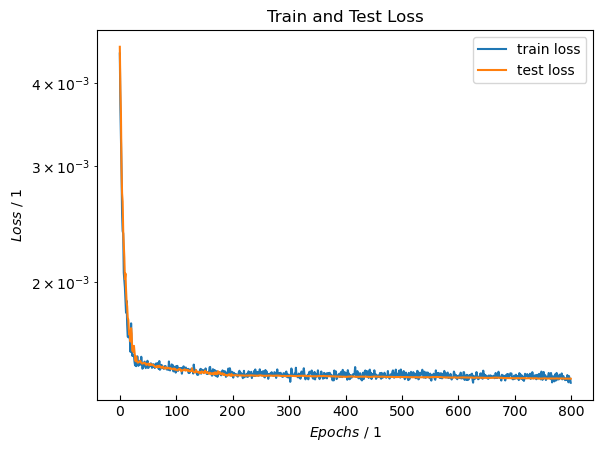

In [9]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Loss$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.show()

#### Parity Plot

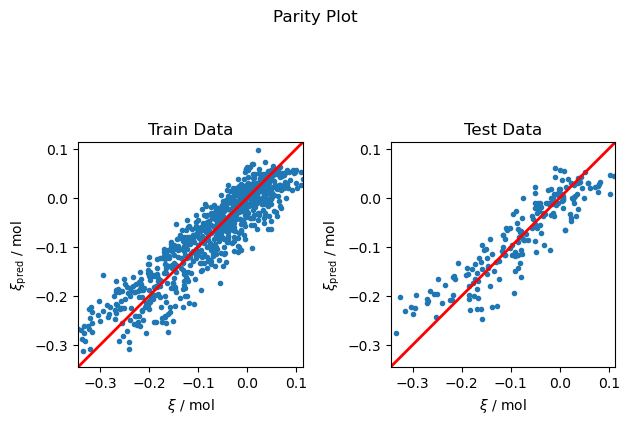

In [10]:
xi_real = []
xi_pred = []
for (X,y) in train_dataloader:
    xi_real = np.append(xi_real, y.numpy())
    xi_pred = np.append(xi_pred, net(X).detach().numpy())

xi_real_test = []
xi_pred_test = []
for (X,y) in test_dataloader:
    xi_real_test = np.append(xi_real_test, y.numpy())
    xi_pred_test = np.append(xi_pred_test, net(X).detach().numpy())

# find the boundaries of X and Y values
bounds = (min(xi_real.min(), xi_pred.min()) - int(0.1 * xi_pred.min()), max(xi_real.max(), xi_pred.max())+ int(0.1 * xi_pred.max()))

fig,ax = plt.subplots(1,2)

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(xi_real, xi_pred, '.')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[0].set_title('Train Data')

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(xi_real_test, xi_pred_test, '.')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].set(xlabel = '$\\xi$ / mol', ylabel = '$\\xi\mathregular{_{pred}}$ / mol')
ax[1].set_title('Test Data')


#plt.legend()
fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

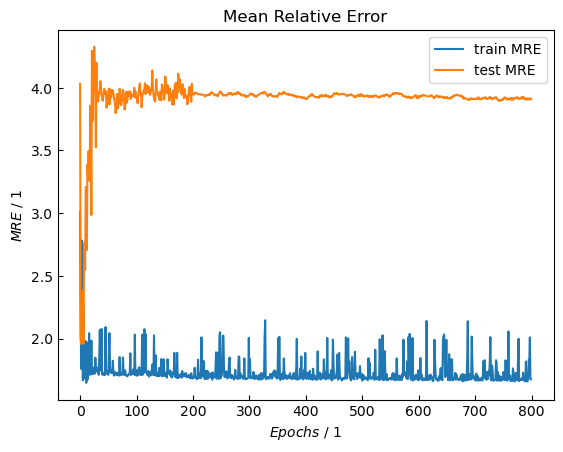

In [11]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_MRE, label='train MRE')
ax.plot(test_MRE, label='test MRE')
plt.title("Mean Relative Error")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.show()

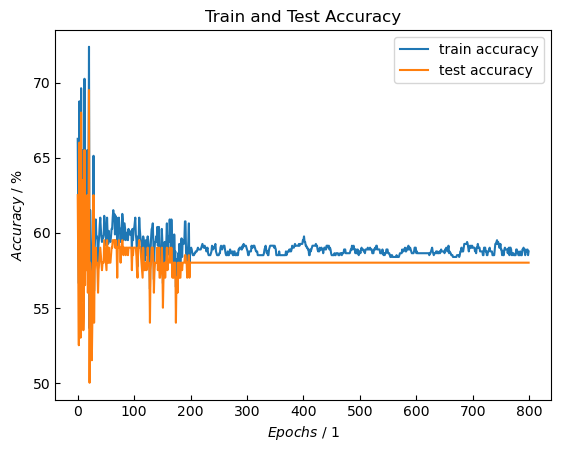

In [12]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.show()

#### Debugging Hilfe

In [13]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y.reshape((-1,1)))
    print(net(X))
    break

tensor([[2.8844, 0.1137, 0.1411, 0.2610, 0.5978],
        [2.8770, 0.2230, 0.0898, 0.1979, 0.7123],
        [2.8564, 0.1106, 0.3901, 0.0598, 0.5501],
        [2.8746, 0.1486, 0.3976, 0.3092, 0.2932],
        [2.8981, 0.1326, 0.0060, 0.9518, 0.0422],
        [2.9053, 0.1314, 0.7077, 0.1869, 0.1054],
        [2.8786, 0.2375, 0.8015, 0.1726, 0.0259],
        [2.8962, 0.1581, 0.3084, 0.6852, 0.0064],
        [2.8483, 0.1358, 0.0333, 0.3123, 0.6544],
        [2.8638, 0.2302, 0.1246, 0.5652, 0.3101],
        [2.8606, 0.1684, 0.8049, 0.0562, 0.1389],
        [2.9166, 0.2458, 0.2051, 0.7422, 0.0527],
        [2.8948, 0.1261, 0.0653, 0.7310, 0.2036],
        [2.8658, 0.1043, 0.0398, 0.9394, 0.0208],
        [2.8404, 0.2008, 0.1002, 0.1346, 0.7652],
        [2.8896, 0.1693, 0.1919, 0.7536, 0.0545],
        [2.8886, 0.2013, 0.0124, 0.8054, 0.1821],
        [2.8272, 0.1356, 0.1571, 0.0265, 0.8164],
        [2.9095, 0.1995, 0.2371, 0.0900, 0.6728],
        [2.8786, 0.1780, 0.0097, 0.2260, 0.7643],


#### Einblick in Netzwerk

In [14]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[ 1.5218e-01,  2.0328e-02, -1.2856e-01, -2.2727e-01, -3.4185e-01],
         [ 3.2245e-01, -4.2546e-02, -4.3903e-01, -3.5057e-01, -4.0133e-02],
         [ 2.4342e-01,  1.0523e-01,  2.0466e-01,  2.0433e-02, -4.3570e-01],
         [-1.1225e-01,  3.6787e-01, -1.6835e-01, -2.1828e-01,  1.3345e-01],
         [ 1.7182e-01,  1.5793e-01, -3.3831e-01,  6.7314e-02, -1.0308e-01],
         [ 1.7874e-01,  2.8195e-01, -1.4830e-01,  2.2074e-01, -8.4795e-02],
         [ 2.4910e-01, -6.3608e-02, -3.6720e-02, -2.4913e-01,  1.1801e-01],
         [-3.6438e-01, -3.6556e-01, -2.4893e-01,  5.8167e-02,  9.9194e-02],
         [-3.6678e-01,  7.4277e-02, -2.6346e-01,  2.2830e-01,  6.3421e-02],
         [-3.3905e-01,  2.6863e-01, -4.3291e-01,  8.3837e-02, -3.0016e-01],
         [-2.5347e-01, -8.9617e-02, -3.2540e-01, -4.3177e-01,  2.0168e-01],
         [ 1.0326e-01, -3.4124e-01, -9.5799e-02,  3.2070e-01, -3.0468e-01],
         [-2.6177e-01,  1.9794e-01,  1.2585e-01, -9.9574e-02,  1.

In [15]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.7144, 0.4328, 0.6364, 0.5766, 0.7359],
        [0.4714, 0.6184, 0.8143, 0.5924, 0.0254]])
tensor([[-4.7914e-05],
        [ 6.8256e-02]], grad_fn=<AddmmBackward0>)
